## Classic GP with Bilby

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bilby
from bilby.core.utils import random
import json

# set up
random.seed(123)
label = "GP"
outdir = "outdir"
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)

sample_dat_path = "../synthetic_data/N11000_AP10_noise0.5_seed1/Size500/Rep3.csv"
sample_dat = pd.read_csv(sample_dat_path)

val_dat_path = "../synthetic_data/N11000_AP10_noise0.5_seed1/N11000_AP10_noise0.5_seed1_meta.json"
with open(val_dat_path, 'r') as f:
    val_dat = json.load(f)

true_betas = np.array(val_dat['beta'])
true_ells = np.array(val_dat['lengthscales'])
active_dims = np.array(val_dat['active_indices'])
true_sigma_noise = val_dat['noise_constant']

from sklearn.model_selection import train_test_split

X = sample_dat.iloc[:, :-1].values  #all columns except the last
y = sample_dat.iloc[:, -1].values   #last column

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=22)

In [2]:
# helper function to compute the RBF kernel
def rbf_kernel(X, ell, sigma_gp):
    N = X.shape[0]
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            diff = X[i] - X[j] / ell
            K[i, j] = sigma_gp**2 * np.exp(-0.5 * np.dot(diff, diff))
    return K
        

In [3]:
# custom likelihood for multi-dimensional linear regression
class HierarchicalGPLikelihood(bilby.Likelihood):
    def __init__(self, X, y):
        # store data
        self.X = np.asarray(X)
        self.y = np.asarray(y)

        # define parameters
        parameters = {}

        # linear coefficients (betas)
        for i in range(self.X.shape[1]):
            parameters[f"beta{i}"] = None
        
        # lengthscales (ells)
        for i in range(self.X.shape[1]):
            parameters[f"ell{i}"] = None

        # noise parameters
        parameters["sigma_noise"] = None
        parameters["sigma_gp"] = None
        
        super().__init__(parameters=parameters)


    def log_likelihood(self):

        betas = np.array([self.parameters[f"beta{i}"] for i in range(self.X.shape[1])])
        ells = np.array([self.parameters[f"ell{i}"] for i in range(self.X.shape[1])])

        sigma_noise = self.parameters["sigma_noise"]
        sigma_gp = self.parameters["sigma_gp"]


        # calculate n
        n = self.X.shape[0]

        # calculate covariance matrix C
        C = rbf_kernel(self.X, ells, sigma_gp)

        # calculate residuals
        residuals = self.y - self.X @ betas
  
        # log_likelihood = (
        #     -0.5 * n * np.log(2 * np.pi) 
        #     -0.5 * np.linalg.slogdet(C + sigma_noise**2 * np.eye(n))[1]
        #     -0.5 *(residuals).T @ np.linalg.inv(C + sigma_noise**2 * np.eye(n)) @ residuals)

        log_likelihood = ( # more stable for computation?
            -0.5 * n * np.log(2 * np.pi) 
            -0.5 * np.linalg.slogdet(C + sigma_noise**2 * np.eye(n))[1]
            -0.5 *(residuals).T @ np.linalg.solve(C + sigma_noise**2 * np.eye(n), residuals))

        return log_likelihood


In [4]:
# model function

def model_function(X, **params): 
    betas = np.array([params[f"beta{i}"] for i in range(X.shape[1])]) # make beta for each column
    return X @ betas 

# make priors
priors = dict()
for i in range(30):
    priors[f"beta{i}"] = bilby.core.prior.Normal(0, 2, f"beta{i}") # define normal priors for each beta coefficient
    priors[f"ell{i}"] = bilby.core.prior.LogNormal(0, 1, f"ell{i}") # define log-normal priors for each lengthscale

    priors["sigma_noise"] = bilby.core.prior.LogNormal(0, 1, "sigma_noise") # define log-normal prior for noise
    priors["sigma_gp"] = bilby.core.prior.LogNormal(0, 1, "sigma_gp") # define log-normal prior for GP noise

# define the likelihood function that we defined earlier
likelihood = HierarchicalGPLikelihood(
    X = Xtrain,
    y = ytrain)

# run MCMC sampler
result = bilby.run_sampler(
    likelihood=likelihood, # likelihood function
    priors=priors, # prior distributions
    sampler="emcee", 
    nwalkers = 200,
    nsteps = 50,
    nburn = 10,
    outdir=outdir,
    label=label
)

16:18 bilby INFO    : Running for label 'GP', output will be saved to 'outdir'
16:18 bilby INFO    : Analysis priors:
16:18 bilby INFO    : beta0=Normal(mu=0, sigma=2, name='beta0', latex_label='beta0', unit=None, boundary=None)
16:18 bilby INFO    : ell0=LogNormal(mu=0, sigma=1, name='ell0', latex_label='ell0', unit=None, boundary=None)
16:18 bilby INFO    : sigma_noise=LogNormal(mu=0, sigma=1, name='sigma_noise', latex_label='sigma_noise', unit=None, boundary=None)
16:18 bilby INFO    : sigma_gp=LogNormal(mu=0, sigma=1, name='sigma_gp', latex_label='sigma_gp', unit=None, boundary=None)
16:18 bilby INFO    : beta1=Normal(mu=0, sigma=2, name='beta1', latex_label='beta1', unit=None, boundary=None)
16:18 bilby INFO    : ell1=LogNormal(mu=0, sigma=1, name='ell1', latex_label='ell1', unit=None, boundary=None)
16:18 bilby INFO    : beta2=Normal(mu=0, sigma=2, name='beta2', latex_label='beta2', unit=None, boundary=None)
16:18 bilby INFO    : ell2=LogNormal(mu=0, sigma=1, name='ell2', latex_l

### Analysis of Results

In [ ]:
result.plot_walkers()
# see outdir/GP_walkers.png

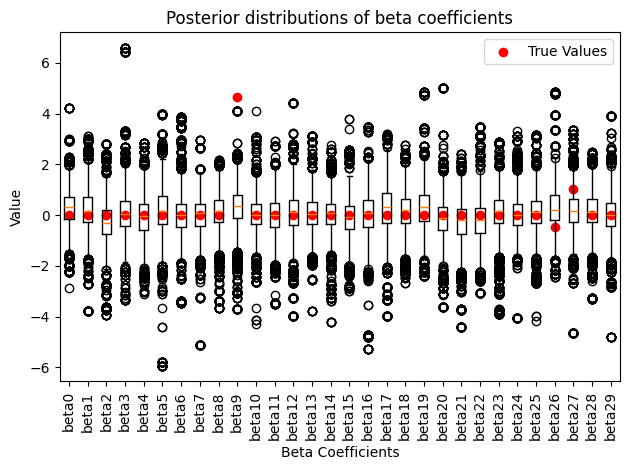

In [41]:
x_positions = np.arange(1, 31)  
plt.boxplot(
    [result.posterior[f'beta{i}'] for i in range(30)],
    tick_labels=[f'beta{i}' for i in range(30)]
)
plt.scatter(x_positions, true_betas, color='red', label='True Values')
plt.xlabel('Beta Coefficients')
plt.xticks(rotation=90)
plt.title('Posterior distributions of beta coefficients')
plt.ylabel('Value')
plt.tight_layout()
plt.legend()
plt.show()


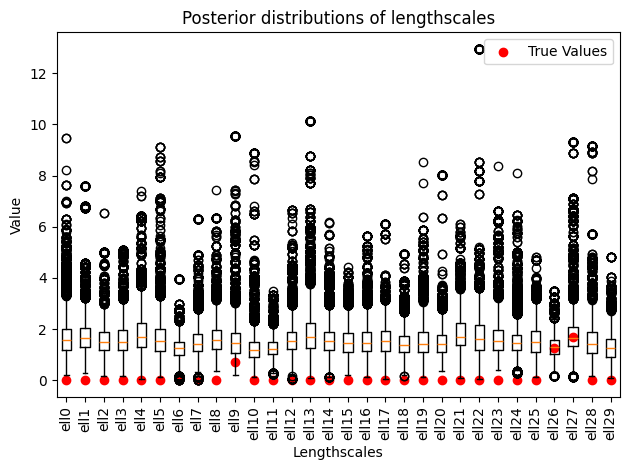

In [47]:
n_features = Xtrain.shape[1]
true_lengthscales = np.zeros(n_features)  # default all 0

for idx, val in zip(active_dims, true_ells):
    true_lengthscales[idx] = val


x_positions = np.arange(1, 31)  
plt.boxplot(
    [result.posterior[f'ell{i}'] for i in range(30)],
    tick_labels=[f'ell{i}' for i in range(30)]
)
plt.scatter(x_positions, true_lengthscales, color='red', label='True Values')
plt.xlabel('Lengthscales')
plt.xticks(rotation=90)
plt.title('Posterior distributions of lengthscales')
plt.ylabel('Value')
plt.tight_layout()
plt.legend()
plt.show()